/tmp/ipykernel_4194212/4147459683.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
/usr1/home/s124mdg


Image: 00001170_049.png
True label(s): Fibrosis

--- Predicted Probabilities ---
Atelectasis: 0.1365
Cardiomegaly: 0.0001
Effusion: 0.0250
Infiltration: 0.0002
Mass: 0.6460
Nodule: 0.0000
Pneumonia: 0.0071
Pneumothorax: 0.0000
Consolidation: 0.3499
Edema: 0.0246
Emphysema: 0.0240
Fibrosis: 0.9683
Pleural_Thickening: 0.0000
Hernia: 0.0839


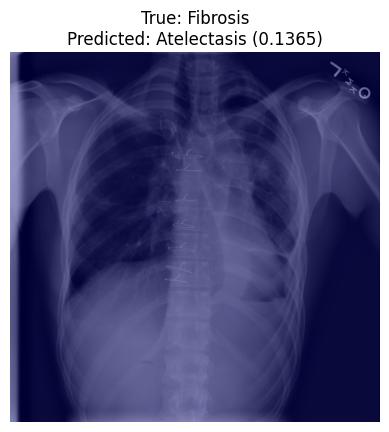

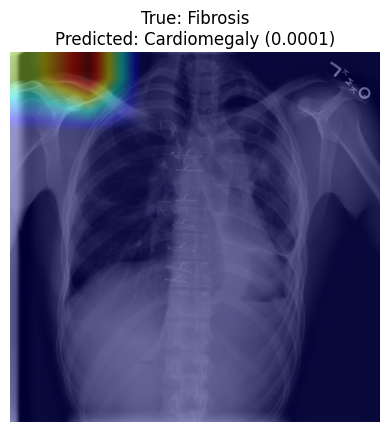

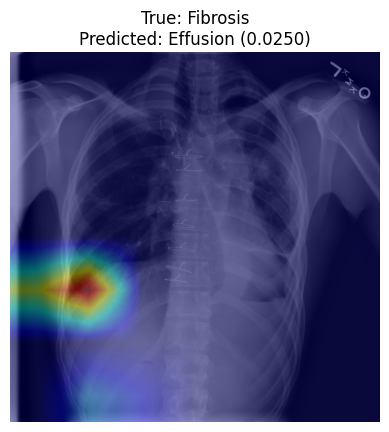

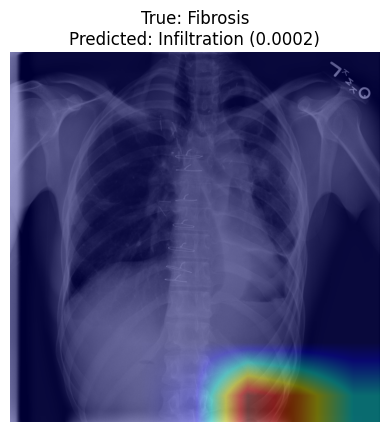

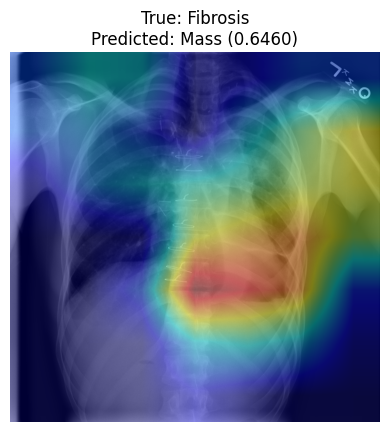

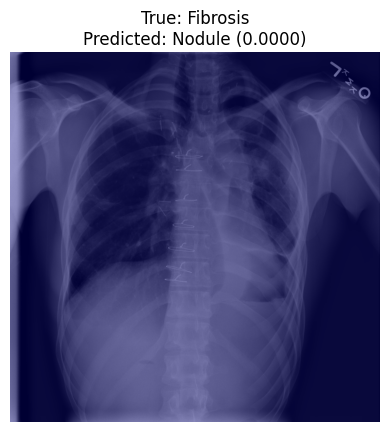

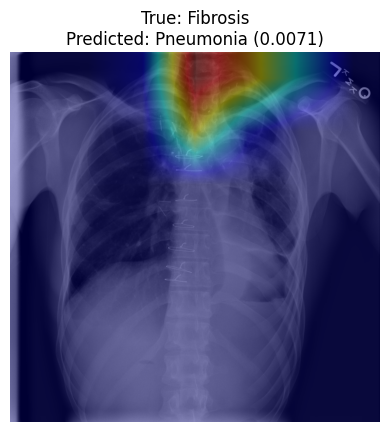

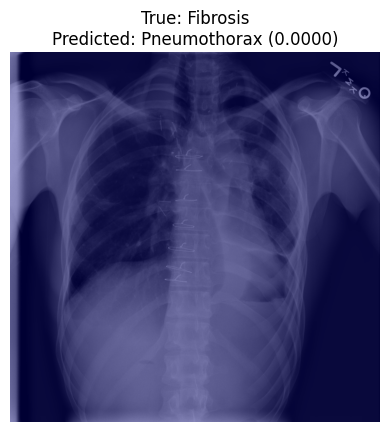

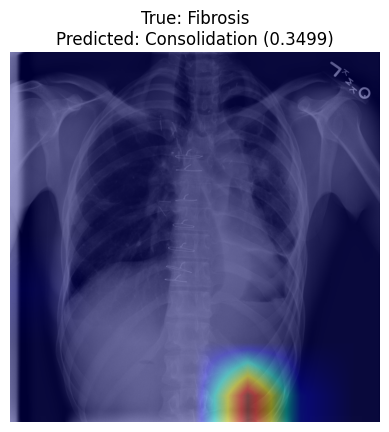

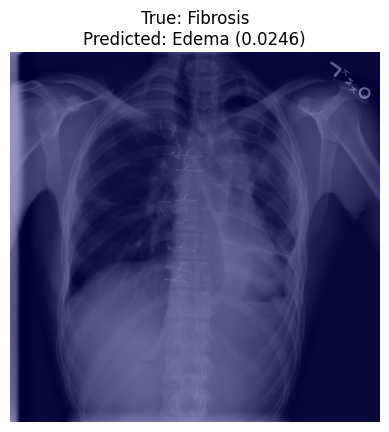

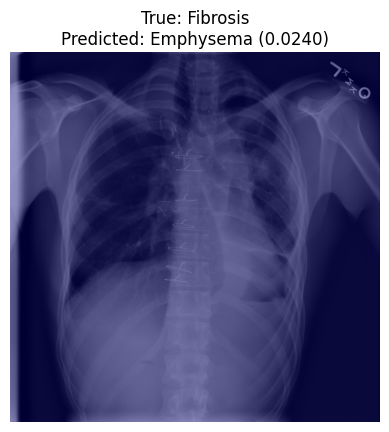

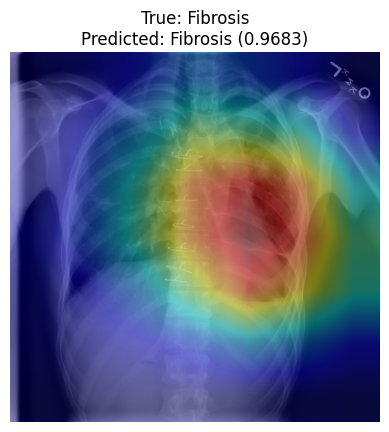

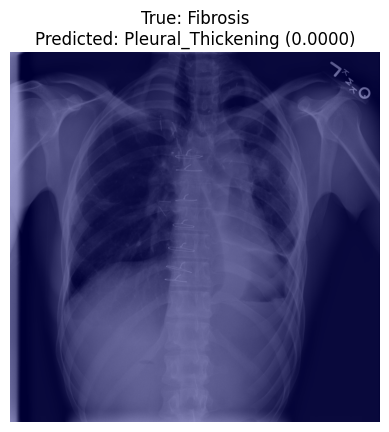

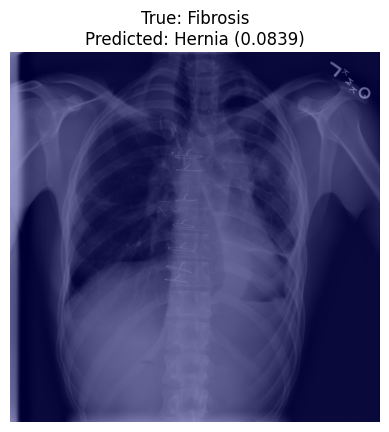

In [21]:
import torch
from torchvision import models, transforms
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd
import os
import random

# === Define the model architecture ===
class DenseNet121MultiLabel(nn.Module):
    def __init__(self, num_labels=14, dropout_rate=0.2):
        super(DenseNet121MultiLabel, self).__init__()
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_labels),
        )

    def forward(self, x):
        x = self.densenet(x)
        x = torch.sigmoid(x)
        return x

# === Grad-CAM implementation ===
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output[0, target_class].backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.squeeze(0)

        for i in range(pooled_gradients.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
        return heatmap

# === Preprocessing ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def apply_heatmap(heatmap, image):
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = 1.0 - heatmap  # invert
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    image_np = np.array(image.convert("RGB"))
    superimposed = cv2.addWeighted(image_np, 0.6, heatmap_color, 0.4, 0)
    return superimposed

# === Main execution ===
def run_gradcam_random(dataset_dir, model_path, class_names=None, csv_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Pick random image from dataset directory
    all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_dir) 
                  for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_images:
        raise FileNotFoundError("No images found in dataset directory.")
    image_path = random.choice(all_images)
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    image_name = os.path.basename(image_path)

    # Get true label from CSV
    true_label = "Unknown"
    if csv_path and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        match = df[df["Image Index"] == image_name]
        if not match.empty:
            true_label = match.iloc[0]["Finding Labels"]

    # Load model
    model = DenseNet121MultiLabel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Grad-CAM setup
    target_layer = model.densenet.features[-1]
    cam = GradCAM(model, target_layer)

    # Get predictions
    output = model(input_tensor)
    probs = output[0].detach().cpu().numpy()

    # Print probabilities for all classes
    print(f"\nImage: {image_name}")
    print(f"True label(s): {true_label}")
    print("\n--- Predicted Probabilities ---")
    for idx, p in enumerate(probs):
        label = class_names[idx] if class_names else f"Class {idx}"
        print(f"{label}: {p:.4f}")

    # Grad-CAM for all classes (no threshold)
    for cls_idx in range(len(probs)):
        heatmap = cam.generate(input_tensor, cls_idx)
        result = apply_heatmap(heatmap, image)

        # Plot
        plt.figure()
        pred_class_name = class_names[cls_idx] if class_names else f"Class {cls_idx}"
        plt.imshow(result)
        plt.title(f"True: {true_label}\nPredicted: {pred_class_name} ({probs[cls_idx]:.4f})")
        plt.axis('off')
        plt.show(block=True)  # keep window open
        plt.pause(0.1)  # small pause to ensure display

# === Example usage ===
if __name__ == "__main__":
    class_names = [
        'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
        'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
        'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
    ]

    run_gradcam_random(
        dataset_dir='dataset/images_001/images',  # folder containing images
        model_path='best_model_weighted_loss.pth',
        class_names=class_names,
        csv_path='dataset/Data_Entry_2017.csv'
    )


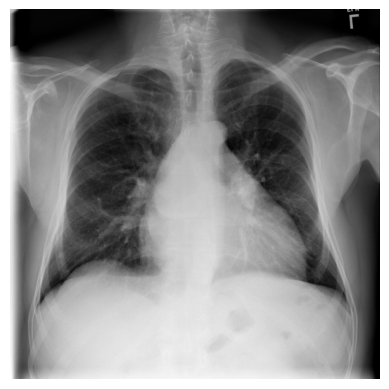

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

def print_image_from_path(image_path):
    img = Image.open(image_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()

print_image_from_path('dataset/images_001/images/00000001_000.png')
